The goal of this notebook is to use ordinary least squares regression to provide golfers with a meaningful way to improve their scoring average. I want to make clear that this regression likely won't be great for predicting scoring averages. There are many variables (nearly 1500 in the dataset) that can be used to predict someone's average golf score. Due to this, it's unlikely that any single variable is going to be able to reliably predict an all-encompassing statistic such as scoring average. So all I want to do is see if there's some facet of golf that players can focus on improving. If they target that part of their game, then perhaps thier scoring average will consequently improve . Thus this OLS regression will aim to justify some sort of mild linear relationship between a predictor variable and scoring average.

<a id='ToC'></a>

# Table of Contents
* [Data Exploration](#data_explore)
    * [Data Cleanup](#data_clean)
    * [Correlation Analysis](#corr_analysis)
* [Ordinary Least Squares Regression Model](#OLS)
    * [OLS Model Analysis](#OLS_analysis)     
* [Summary](#summary)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn import metrics
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from sklearn.model_selection import train_test_split
from scipy.stats import gaussian_kde
from statsmodels.graphics.gofplots import ProbPlot
from scipy import stats

<a id='data_explore'></a>

# Data Exploration
[Back to Table of Contents](#ToC)

This dataset consists of many measures for individual golfers on the PGA Tour. Each golfer has data for nearly 1500 variables, which is also grouped by date. 
So after each week, each golfer's data is updated and a new entry is made for them.

In [2]:
# Load CSV file data into a dataframe.
df = pd.read_csv("/kaggle/input/pga-tour-20102018-data/2019_data.csv")
df.head()

,Player Name,Date,Statistic,Variable,Value
0,Cameron Champ,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),78
1,Rory McIlroy,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),72
2,Luke List,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),66
3,Dustin Johnson,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),73
4,Wyndham Clark,2019-08-25,Driving Distance,Driving Distance - (ROUNDS),87


<a id='data_clean'></a>

## Data Cleanup
[Back to Table of Contents](#ToC)

In [3]:
# Transpose the statistic variables such that there is 1 golfer per row, each with columns for
# every statistic variable.
df = df.set_index(['Player Name', 'Variable', 'Date'])['Value'].unstack('Variable').reset_index()

# Typecast the Date column to datetime objects so they can be quantified.
df['Date'] = pd.to_datetime(df['Date'])

# Select data from 8/25/19, which was the end of the 2018-2019 PGA season.
df = df[(df['Date'] == '2019-08-25')]

# Typecast data points to numeric data types, except Player Name and Date columns.
df.iloc[:, 2:] = df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce').fillna(0)

df.head()

Variable,Player Name,Date,% of Potential Pts won - FedExCup Playoffs - (# OF TOP 10'S),% of Potential Pts won - FedExCup Playoffs - (# OF WINS),% of Potential Pts won - FedExCup Playoffs - (%),% of Potential Pts won - FedExCup Playoffs - (EVENTS),% of Potential Pts won - FedExCup Playoffs - (PLAYOFF POINTS WON),% of Potential Pts won - FedExCup Playoffs - (POTENTIAL PTS),% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S),% of Potential Pts won - FedExCup Regular Season - (# OF WINS),...,Total Eagles - (ROUNDS),Total Eagles - (TOTAL),Total Hole Outs - (HOLE OUTS),Total Hole Outs - (ROUNDS),Total Money (Official and Unofficial) - (EVENTS),Total Money (Official and Unofficial) - (MONEY),Total Putting - (EVENTS),Total Putting - (TOTAL),Victory Leaders - (EVENTS),Victory Leaders - (VICTORIES)
9,NaN,2019-08-25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61,Aaron Baddeley,2019-08-25,0.0,0.0,0.00,0.0,0.0,0.0,3.0,0.0,...,55.0,4.0,11.0,55.0,18.0,0.0,18.0,85.7,18.0,0.0
92,Aaron Pike,2019-08-25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,Aaron Rai,2019-08-25,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0
154,Aaron Wise,2019-08-25,0.0,0.0,2.03,21.0,41.0,0.0,1.0,0.0,...,72.0,3.0,6.0,72.0,21.0,0.0,21.0,268.8,21.0,0.0


The data seems to be zero-inflated. This makes sense because there are more than 1000 golfers in the dataset, and many either don't play often, or certain data just isn't collected from them because they're lesser known players.

In [4]:
# Check all of the statistic variables available in the dataset.
for col in df.columns[2:]:
    print(col)

% of Potential Pts won - FedExCup Playoffs - (# OF TOP 10'S)
% of Potential Pts won - FedExCup Playoffs - (# OF WINS)
% of Potential Pts won - FedExCup Playoffs - (%)
% of Potential Pts won - FedExCup Playoffs - (EVENTS)
% of Potential Pts won - FedExCup Playoffs - (PLAYOFF POINTS WON)
% of Potential Pts won - FedExCup Playoffs - (POTENTIAL PTS)
% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S)
% of Potential Pts won - FedExCup Regular Season - (# OF WINS)
% of Potential Pts won - FedExCup Regular Season - (%)
% of Potential Pts won - FedExCup Regular Season - (EVENTS)
% of Potential Pts won - FedExCup Regular Season - (POINTS WON)
% of Potential Pts won - FedExCup Regular Season - (POTENTIAL PTS)
1-Putts per Round - (AVG)
1-Putts per Round - (ROUNDS)
1-Putts per Round - (TOTAL 1 PUTTS)
1-Putts per Round - (TOTAL ROUNDS)
11-25 Final Round Performance - (# OF TIMES IMPROVED)
11-25 Final Round Performance - (% TIMES IMPROVED)
11-25 Final Round Performance - (EVENTS)
2-Pu

In [5]:
# Only keep the average, percentage, and points variables, otherwise there will be many 1.0 co-efficients cluttering the analysis.
for col in df.columns:
    if 'AVG' not in col and '%' not in col and 'POINTS' not in col:
        del df[col]

In [6]:
# Since the data is zero-inflated, replace 0 values with NaN values before analyzing correlations. Otherwise the correlations will also be inflated.

corr_df = pd.concat([df.iloc[:, :2], df.iloc[:, 2:].replace(0, np.nan)], axis=1)

corr_df.head()

Variable,% of Potential Pts won - FedExCup Playoffs - (# OF TOP 10'S),% of Potential Pts won - FedExCup Playoffs - (# OF WINS),% of Potential Pts won - FedExCup Playoffs - (%),% of Potential Pts won - FedExCup Playoffs - (EVENTS),% of Potential Pts won - FedExCup Playoffs - (PLAYOFF POINTS WON),% of Potential Pts won - FedExCup Playoffs - (POTENTIAL PTS),% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S),% of Potential Pts won - FedExCup Regular Season - (# OF WINS),% of Potential Pts won - FedExCup Regular Season - (%),% of Potential Pts won - FedExCup Regular Season - (EVENTS),...,Tenth Tee Early Par 4 Scoring Average - (AVG),Tenth Tee Early Par 5 Scoring Average - (AVG),Tenth Tee Early Scoring Average - (AVG),Tenth Tee Late Par 3 Scoring Average - (AVG),Tenth Tee Late Par 4 Scoring Average - (AVG),Tenth Tee Late Par 5 Scoring Average - (AVG),Tenth Tee Late Scoring Average - (AVG),Top 10 Final Round Performance - (% TIMES IMPROVED),Top 5 Final Round Performance - (% TIMES IMPROVED),Total Distance Efficiency - (AVG.)
9,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,0.0,0.0,NaN,NaN,NaN,NaN,3.0,NaN,5.28,18.0,...,4.09,5.04,72.50,3.02,3.98,4.57,69.77,50.0,50.0,2.544
92,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,0.0,0.0,2.03,21.0,41.0,NaN,1.0,NaN,3.77,21.0,...,4.02,4.51,69.23,3.04,3.96,4.50,69.29,NaN,NaN,2.643


<a id='corr_analysis'></a>

## Correlation Analysis
[Back to Table of Contents](#ToC)

I chose scoring average as the dependent variable because I figured it would be a good measure for overall golf performance. Now from this point, the task is to find another statistical variable that has a linear relationship to scoring average. If the relationship is strong enough and significant, then it can be used as the independent variable for predicting in the regression model.

In [7]:
dependent_var = 'Scoring Average - (AVG)'

In [8]:
# Create a sorted Pierson correlation matrix to understand variable pair relationships.

matrix_df = corr_df.corr()
unstack_matrix = matrix_df.unstack()
sorted_matrix = unstack_matrix.sort_values(kind='quicksort', ascending=True, na_position='first').dropna()
  
print('ALL CORRELATIONS ARE BETWEEN \"{}\" AND AN ARBITRARY VARIABLE'.format(dependent_var))
print('='*95+'\n')
    
count = 0
for pair, val in sorted_matrix.items():
    if pair[1] == dependent_var and count < 20:
        print('{:68} PIERSON CO-EFF.'.format(pair[0] + ' ,'))
        print('{:68} {}'.format(pair[1], val))
        print('-'*88)
        count += 1

ALL CORRELATIONS ARE BETWEEN "Scoring Average - (AVG)" AND AN ARBITRARY VARIABLE

Percentage of potential money won - (%) ,                            PIERSON CO-EFF.
Scoring Average - (AVG)                                              -0.7740769468826227
----------------------------------------------------------------------------------------
% of Potential Pts won - FedExCup Regular Season - (%) ,             PIERSON CO-EFF.
Scoring Average - (AVG)                                              -0.7703528290509747
----------------------------------------------------------------------------------------
Official World Golf Ranking - (POINTS GAINED) ,                      PIERSON CO-EFF.
Scoring Average - (AVG)                                              -0.7676635760634778
----------------------------------------------------------------------------------------
Percentage of Available Purse Won - (%) ,                            PIERSON CO-EFF.
Scoring Average - (AVG)                     

It's important to note that in golf, a lower score is a better score. So we're looking for a strong negative linear relationship. That's to say that as the predictor variable increases, the scoring average will decrease.

In [9]:
# Select the highly correlated pairs that contain the dependent variable.

pairs = []

for pair, val in sorted_matrix.items():
    var1, var2 = pair
    if var2 == dependent_var:
        pairs.append([var1, var2, val])
        
print(*(pair for pair in pairs[:10]), sep='\n')

['Percentage of potential money won - (%)', 'Scoring Average - (AVG)', -0.7740769468826227]
['% of Potential Pts won - FedExCup Regular Season - (%)', 'Scoring Average - (AVG)', -0.7703528290509747]
['Official World Golf Ranking - (POINTS GAINED)', 'Scoring Average - (AVG)', -0.7676635760634778]
['Percentage of Available Purse Won - (%)', 'Scoring Average - (AVG)', -0.7662700860615613]
["% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S)", 'Scoring Average - (AVG)', -0.7516875832553787]
['Official World Golf Ranking - (TOTAL POINTS)', 'Scoring Average - (AVG)', -0.7459976141536425]
['Official World Golf Ranking - (AVG POINTS)', 'Scoring Average - (AVG)', -0.7419436750722389]
['FedExCup Season Points - (POINTS)', 'Scoring Average - (AVG)', -0.6832480825837313]
['% of Potential Pts won - FedExCup Regular Season - (POINTS WON)', 'Scoring Average - (AVG)', -0.6832480825837313]
['Birdie or Better Percentage - (%)', 'Scoring Average - (AVG)', -0.6633577846699888]


In [10]:
# Test the significance of the correlations with the dependent variable using p-values of the co-effs.

lin_regress_dict = {}

for pair in pairs:
    var1_list = df[pair[0]].values.tolist()
    var2_list = df[pair[1]].values.tolist()
    (slope, intercept, r_value, p_value, std_err) = linregress(var1_list, var2_list)
    
    key_name = "{}, {}".format(pair[0], pair[1])
    lin_regress_dict[key_name] = ((slope, intercept, r_value, p_value, std_err))
    
# Keep the most significantly correlated pairs
for key, val in list(lin_regress_dict.items()):
    if val[3] > 0.05:  # p-value > 0.05
        del lin_regress_dict[key]
        
count = 0
for k,v in lin_regress_dict.items():
    if count <= 5:
        print('{} :\n{}\n'.format(k, v))
        count += 1

Percentage of potential money won - (%), Scoring Average - (AVG) :
(5.381674009014152, 4.52039975238837, 0.5847188221492998, 6.9034227405575465e-115, 0.21194913783365338)

% of Potential Pts won - FedExCup Regular Season - (%), Scoring Average - (AVG) :
(5.6890903679369, 5.18241446816625, 0.6536991369106911, 2.100499126212362e-152, 0.18695370093734132)

Official World Golf Ranking - (POINTS GAINED), Scoring Average - (AVG) :
(0.3981148907740719, 4.267216140989954, 0.5274860670164149, 5.807823895253145e-90, 0.018201512435540627)

Percentage of Available Purse Won - (%), Scoring Average - (AVG) :
(26.235882846942317, 4.857094281426137, 0.5711430310317552, 1.5821519707808137e-108, 1.0703578728690728)

% of Potential Pts won - FedExCup Regular Season - (# OF TOP 10'S), Scoring Average - (AVG) :
(14.772565706529015, 4.663177734484051, 0.7239047306037958, 2.68247277619874e-202, 0.3996453262581878)

Official World Golf Ranking - (TOTAL POINTS), Scoring Average - (AVG) :
(0.2808090723180946, 3

In [11]:
# Sort the correlated pairs by p-value.
sorted_pvalues = sorted(lin_regress_dict.items(), key=lambda x: x[1][3])

# Print the most significantly correlated variables to the dependent variable.
print('VARIABLE CORRELATIONS TO \"{}\", SORTED BY P-VALUE\n'.format(dependent_var))
print('{:66} {:13} {}'.format('VARIABLE NAME', 'R-VALUE', 'P-VALUE'))
print('='*88)

for pair in sorted_pvalues[:10]:
    var1, var2 = pair[0].split(', ')
    slope, intercept, r_value, p_value, std_err = pair[1]
    
    print('{:60}   |   {:6.4f}   |   {:4}'.format(var1, r_value.round(4), p_value))
    print('-'*88)  

VARIABLE CORRELATIONS TO "Scoring Average - (AVG)", SORTED BY P-VALUE

VARIABLE NAME                                                      R-VALUE       P-VALUE
Birdie or Better Percentage - (%)                              |   0.9955   |    0.0
----------------------------------------------------------------------------------------
Par Breakers - (%)                                             |   0.9955   |    0.0
----------------------------------------------------------------------------------------
Birdie Average - (AVG)                                         |   0.9955   |    0.0
----------------------------------------------------------------------------------------
Par 5 Birdie or Better Leaders - (%)                           |   0.9926   |    0.0
----------------------------------------------------------------------------------------
Birdie or Better Conversion Percentage - (%)                   |   0.9962   |    0.0
-----------------------------------------------------------

After looking through the correlations, I decided to choose average driving distance as the predictor for the regression. There are many variables that have a better linear relationship with scoring average, but most are not meaningful. There are many variables that are the same statistic but are measured differently. For example, "Top 10 Finishes - (1ST)" and "Top 10 Finishes - (TOP 10)". This correlation will be high because when someone finishes in first place, they're also finishing in the top 10. Another example of a pair that isn't significant for our use would be "Birdie Average - (AVG)" and "Scoring Average - (AVG)". These two are always mutually inclusive because in order to increase or decrease one, the other is going to follow suit. Besides that, advising someone to increase their birdie average in order to improve their scoring average is essentially just telling them to improve their scoring average. I was looking for a predictor that's a more specific part of someone's golf game, so they can focus on it and hopefully improve their overall game.

<a id='OLS'></a>

# Ordinary Least Squares Regression
[Back to Table of Contents](#ToC)

In this case, it's a good idea to also remove the zeros from the data before using it for the OLS model. The cluster of zeros could
create significant bias with the model because there are so many of them.

In [12]:
independent_var = 'Driving Distance - (AVG.)'

In [13]:
# Use original dataframe because we can't input NaN values into the OLS model. We can simply remove
# the zeros from the original dataframe.
old_x = pd.DataFrame(df[independent_var])
old_y = pd.DataFrame(df[dependent_var])

new_df = pd.concat([old_x, old_y], axis=1)

# Drop entire variables that contain zero values.
for idx, row in new_df.iterrows():
    if row[1] <= 0:
        new_df.drop(idx, axis=0, inplace=True)

new_x = pd.DataFrame(new_df[independent_var])
new_y = pd.DataFrame(new_df[dependent_var])

new_df.head()

,Driving Distance - (AVG.),Scoring Average - (AVG)
61,286.3,70.783
154,302.6,70.739
185,293.3,70.580
261,291.2,70.545
292,292.0,71.464


In [14]:
# I decided to skip cross validation because the population size is so small to begin with.
#x_train, x_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.2)
# Concatenate the variables into one dataframe for easier reference.
#train_df = pd.concat([x_train, y_train], axis=1)

train_df = pd.concat([new_x, new_y], axis=1)

train_df.head()

,Driving Distance - (AVG.),Scoring Average - (AVG)
61,286.3,70.783
154,302.6,70.739
185,293.3,70.580
261,291.2,70.545
292,292.0,71.464


In [15]:
# Generate an Ordinary Least Squares regression model.

X = sm.add_constant(new_x)
Y = new_y

ols_model = sm.OLS(Y, X).fit()

print(ols_model.summary())

                               OLS Regression Results                              
Dep. Variable:     Scoring Average - (AVG)   R-squared:                       0.084
Model:                                 OLS   Adj. R-squared:                  0.079
Method:                      Least Squares   F-statistic:                     16.97
Date:                     Tue, 02 Jun 2020   Prob (F-statistic):           5.70e-05
Time:                             13:19:52   Log-Likelihood:                -186.09
No. Observations:                      188   AIC:                             376.2
Df Residuals:                          186   BIC:                             382.7
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

The adjusted co-efficient of determination is very low, but that was expected. Golf is a complicated sport, there are many different parts of golf that all contribute towards overall performance. This model explains about 7.9% of the variation in scoring average. Although this model could never be used for reliable predicting, it can still be useful. The remainder of the summary looks good, the error distribution seems to be Gaussian. 

[](http://)<a id='OLS_analysis'></a>

## OLS Model Analysis
[Back to Table of Contents](#ToC)

In [16]:
# Set variables for info from the model, to use for analysis.

# Model fitted values.
ols_model_fitted_y = ols_model.fittedvalues

# Model residuals.
ols_model_residuals = ols_model.resid

# Normalized residuals.
ols_model_norm_residuals = ols_model.get_influence().resid_studentized_internal

# Absolute squared normalized residuals.
ols_model_norm_residuals_abs_sqrt = np.sqrt(np.abs(ols_model_norm_residuals))

# Leverage.
ols_model_leverage = ols_model.get_influence().hat_matrix_diag

Text(272, 69.5, 'y = -0.0234x + 77.8675')

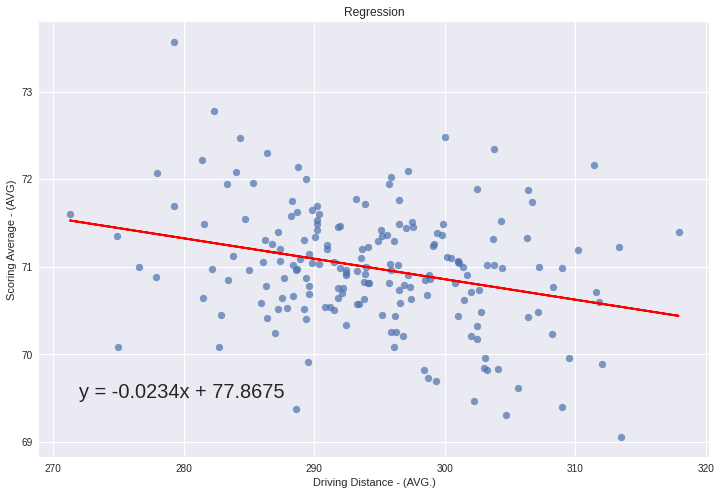

In [17]:
# Regression plot.

plt.style.use('seaborn')

fig2, ax1 = plt.subplots(1, 1, figsize=(12, 8))

ax1.scatter(new_x, new_y, alpha=0.7)
ax1.plot(new_x, ols_model_fitted_y, color='red', linewidth=2)

ax1.set_title('Regression')
ax1.set_xlabel(independent_var)
ax1.set_ylabel(dependent_var)
ax1.text(272, 69.5,'y = -0.0234x + 77.8675', fontsize=20)

There is a clear negative linear relationship between the predictor and response variable.

Text(1, 0.5, 'mean = 0.0000\nstd = 0.6511')

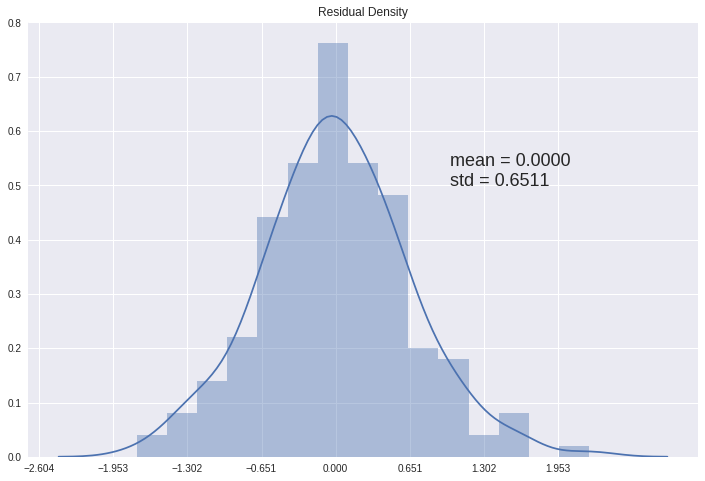

In [18]:
# Residuals density plot

mean = np.mean(ols_model_residuals)
std = np.std(ols_model_residuals)

kde = gaussian_kde(ols_model_residuals)
covf = kde.covariance_factor()
bw = covf * std
     
fig3, ax1 = plt.subplots(1, 1, figsize=(12, 8))

sns.distplot(ols_model_residuals, kde_kws={'bw': bw})

ax1.set_title('Residual Density')
ax1.xaxis.set_ticks(np.arange(-2.604, 2.604, 0.651))
ax1.text(1, 0.5, "mean = {:.4f}\nstd = {:.4f}".format(mean, std), fontsize=18)

As hinted by the model summary, the distribution of the residuals appears to be normal.

In [19]:
# Test if residuals are normally distributed using a test that factors skew and kurtosis.

s, pval = stats.normaltest(ols_model_residuals)

if pval > 0.05:
    print('There is NOT enough evidence to conclude that the distribution is NOT normally distributed.')
else:
    print('There is enough evidence to conclude that the distribution is NOT normally distributed')

There is NOT enough evidence to conclude that the distribution is NOT normally distributed.


Text(0, 0.5, 'Residuals')

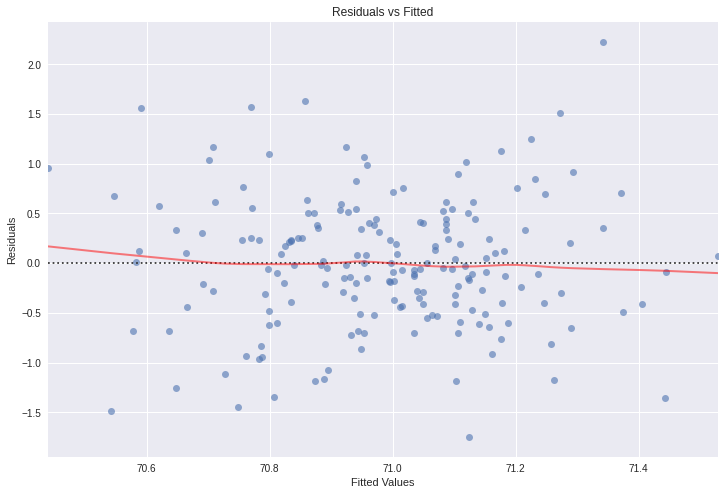

In [20]:
# Residuals vs Fitted plot.

fig5, ax1 = plt.subplots(1, 1, figsize=(12, 8))

sns.residplot(ols_model_fitted_y, train_df[dependent_var], lowess=True, ax=ax1, \
              scatter_kws={'alpha': 0.6}, line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})

ols_model_fitted_y
ax1.set_title('Residuals vs Fitted')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')

The residuals certainly appear homoskedastic, points are uniformly centered around the 0.0 center line.

Text(0, 0.5, 'Standardized Residuals')

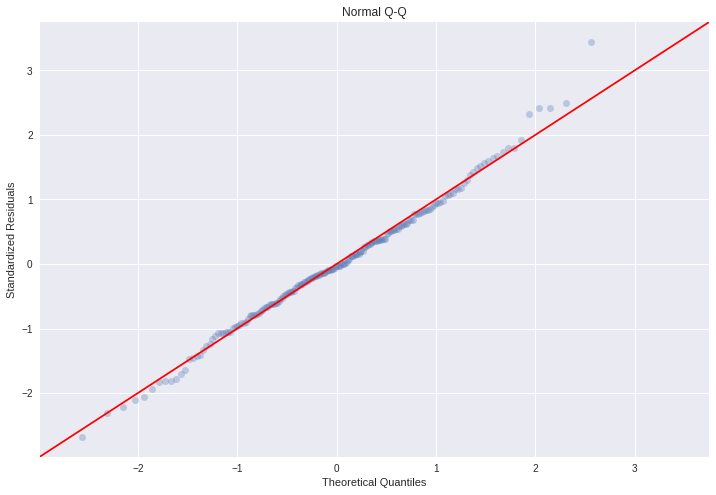

In [21]:
# Normal Q-Q plot.

fig4, ax1 = plt.subplots(figsize=(12, 8))

QQ = ProbPlot(ols_model_norm_residuals)

QQ.qqplot(line='45', alpha=0.3, lw=1, color='#4c72b0', ax=ax1)

ax1.set_title('Normal Q-Q')
ax1.set_xlabel('Theoretical Quantiles')
ax1.set_ylabel('Standardized Residuals')

This capitalizes on the normal distribution assumption. Visually, atleast 95% of the residuals are within 2 standard deviations of the mean. There are a few points in the top right that grab my attention. They're at the edge of the distribution and they have larger residual values than the rest. These points should be examined in the proceding plots to determine if they have too much influence on the model.

Text(0, 0.5, 'Standardized Residuals')

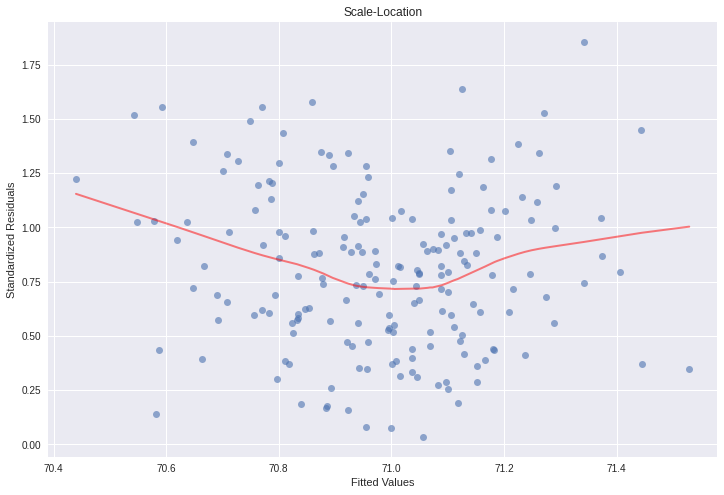

In [22]:
# Scale-Location plot.

fig6, ax1 = plt.subplots(1, 1, figsize=(12, 8))

sns.regplot(ols_model_fitted_y, ols_model_norm_residuals_abs_sqrt, ci=False, \
            lowess=True, scatter_kws={'alpha': 0.6}, ax=ax1, \
            line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})

ax1.set_xlim(min(ols_model_fitted_y)-0.05, max(ols_model_fitted_y)+0.05)
ax1.set_title('Scale-Location')
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Standardized Residuals')

In this plot, there appears to be possible heteroskedasticity. Perhaps the independent variable data did not have constant variance?

In [23]:
# Use Breush-Pagan Test to check for heteroskedasticity.

test = smd.het_breuschpagan(ols_model_residuals, ols_model.model.exog)

if test[1] > 0.05:
    print('There is not enough evidence to conclude that there is heteroskedasticity in the data.')
else:
    print('There is enough evidence to conclude that there is heteroskedasticity in the data.')

There is not enough evidence to conclude that there is heteroskedasticity in the data.


Text(0, 0.5, 'Standardized Residuals')

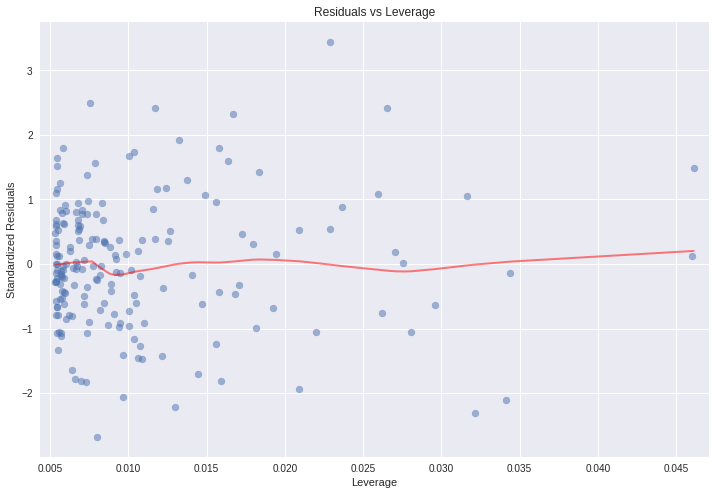

In [24]:
# Residuals vs Leverage plot.

fig7, ax1 = plt.subplots(figsize=(12,8))

plt.scatter(ols_model_leverage, ols_model_norm_residuals, alpha=0.5)

sns.regplot(ols_model_leverage, ols_model_norm_residuals, ax=ax1, \
              scatter=False, ci=False, lowess=True, \
              line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})

ax1.set_xlim(min(ols_model_leverage)-0.001, max(ols_model_leverage)+0.001)
ax1.set_title('Residuals vs Leverage')
ax1.set_xlabel('Leverage')
ax1.set_ylabel('Standardized Residuals')

The final analysis plot doesn't show any points that could be outliers. There are a handful that have more leverage than the majority of points, but comparatively, it isn't much more leverage.

<a id='summary'></a>

# Summary
[Back to Table of Contents](#ToC)

Overall, the model fulfills the ordinary least squares regression requirements. The model's errors are: independent of driving distance, have constant variance, a mean of zero, are not correlated with eachother, and have a normal distribution. Also, the predictor and response variables have a linear relationship and there aren't any large outliers from the model. The only caveat of the model is it's accuracy, which doesn't negate its usefullness. An adjusted r^2 value means that golfers can expect to affect their scoring average by 7.9%. So if they can increase their average driving distance by 20 yards, their scoring average would improve by -0.08. It's not much but as stated earlier, golf has many moving parts. The analysis of this dataset taught me that there isn't one aspect of golf that leads to better scores. Truly every part of golf, from driving to putting, plays an almost equal role in overall performance.

The next step towards finding accurate and significant predictors for golf success, would be to make a multiple regression model. If we can find several predictors, then together they can provide a more accurate prediction. Naturally we would be taking into account more aspects of golf, therefore more of the overall variation in scoring average could be accounted for. The problem would be to sort through the multicollinearity of this data set. Many variables are closely linked, so we must be careful when choosing predictors. 

In [25]:
# Use regression equation to roughly predict scoring average improvement based on increase in driving distance.

predictions = [(x,
               (lambda x: -0.0486*x)(x),
               (lambda x: -0.0486*x)(x)*0.079) for x in range(5, 101, 5)]

print('{:20} {:16}'.format('YARDS ADDED TO', 'SCORING AVG'))
print('{:20} {:20} {}'.format('AVG DRIVE DIST', 'IMPROVEMENT', 'ADJUSTED'))
print('='*50)

for x, y, z in predictions:
    print('{:>14} {:17.2f} {:17.2f}'.format('+'+str(x)+' yards', y, z))

YARDS ADDED TO       SCORING AVG     
AVG DRIVE DIST       IMPROVEMENT          ADJUSTED
      +5 yards             -0.24             -0.02
     +10 yards             -0.49             -0.04
     +15 yards             -0.73             -0.06
     +20 yards             -0.97             -0.08
     +25 yards             -1.21             -0.10
     +30 yards             -1.46             -0.12
     +35 yards             -1.70             -0.13
     +40 yards             -1.94             -0.15
     +45 yards             -2.19             -0.17
     +50 yards             -2.43             -0.19
     +55 yards             -2.67             -0.21
     +60 yards             -2.92             -0.23
     +65 yards             -3.16             -0.25
     +70 yards             -3.40             -0.27
     +75 yards             -3.65             -0.29
     +80 yards             -3.89             -0.31
     +85 yards             -4.13             -0.33
     +90 yards             -4.37            